In [41]:
# Import the library
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

In [5]:
def check_duplicates(dataframe):
  duplicated = dataframe.duplicated(keep=False)
  if duplicated.any():
    some_duplicates = dataframe[duplicated].sort_values(by=dataframe.columns.to_list())
    print(f"Dữ liệu bị trùng, số dòng trùng là:{some_duplicates.shape[0]}")
    print(f"Một vài dòng bị trùng ví dụ:\n {some_duplicates.head(6)}")
  else:
    print('Dữ liệu không bị trùng')
# defind a method to check null percentage of the features
def check_null_percentage(df):
    missing_info = pd.DataFrame(np.array(df.isnull().sum().sort_values(ascending=False).reset_index())\
                ,columns=['Columns','Missing_Percentage'])\
                .query("Missing_Percentage > 0")\
                .set_index('Columns')
    return 100*missing_info/df.shape[0]

In [62]:
data = pd.read_csv('result_data/customer_segment_data.csv')
data

,customer_id,Recency,Frequency,Monetary,RFM_Cluster
0,1,545,1,11.77,RISK
1,2,534,2,89.00,REGULAR
2,3,33,6,156.46,BIG SPENDER
3,4,200,4,100.50,REGULAR
4,5,178,11,385.61,BIG SPENDER
...,...,...,...,...,...
23565,23566,462,1,36.00,RISK
23566,23567,462,1,20.97,RISK
23567,23568,434,3,121.70,REGULAR
23568,23569,462,1,25.74,RISK


In [63]:
check_null_percentage(data)

NameError: name 'check_null_percentage' is not defined

In [64]:
check_duplicates(data)

NameError: name 'check_duplicates' is not defined

In [ ]:
# Remove duplicated rows
print("Số dòng của dữ liệu:", data.shape[0])
data = data.drop_duplicates().reset_index(drop=True)
print("Số dòng của dữ liệu sau khi loại bỏ trùng:", data.shape[0])
check_duplicates(data)

Số dòng của dữ liệu: 6919
Số dòng của dữ liệu sau khi loại bỏ trùng: 6898
Dữ liệu không bị trùng


In [ ]:
current_labels = [2,0,3,1]
desired_labels = ['STARS','BIG SPENDER','REGULAR','RISK']
map_dict_hc = dict(zip(current_labels, desired_labels))

In [65]:
map_dict_hc

{2: 'STARS', 0: 'BIG SPENDER', 3: 'REGULAR', 1: 'RISK'}

In [66]:
inverse_map = {map_dict_hc[k] : k for k in map_dict_hc}
inverse_map

{'STARS': 2, 'BIG SPENDER': 0, 'REGULAR': 3, 'RISK': 1}

In [67]:
data['target'] = data['RFM_Cluster'].map(inverse_map)
data

,customer_id,Recency,Frequency,Monetary,RFM_Cluster,target
0,1,545,1,11.77,RISK,1
1,2,534,2,89.00,REGULAR,3
2,3,33,6,156.46,BIG SPENDER,0
3,4,200,4,100.50,REGULAR,3
4,5,178,11,385.61,BIG SPENDER,0
...,...,...,...,...,...,...
23565,23566,462,1,36.00,RISK,1
23566,23567,462,1,20.97,RISK,1
23567,23568,434,3,121.70,REGULAR,3
23568,23569,462,1,25.74,RISK,1


In [68]:
X = data.drop(['customer_id', 'RFM_Cluster', 'target'], axis = 1)
y = data.target

In [69]:
y.value_counts()

1    11907
3     5668
0     4783
2     1212
Name: target, dtype: int64

In [83]:
#Splitting the dataset into the Training and Test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (16499, 3) (16499,)
Test set: (7071, 3) (7071,)


In [84]:
display(y_train.value_counts(), y_test.value_counts())

1    8338
3    3952
0    3356
2     853
Name: target, dtype: int64

1    3569
3    1716
0    1427
2     359
Name: target, dtype: int64

In [85]:
from sklearn.preprocessing import RobustScaler, StandardScaler
# Khoi tao scaler
# scaler = RobustScaler()
scaler = StandardScaler()

# fit_transfrom cho tập train
X_train = scaler.fit_transform(X_train) 

# Chỉ TRANSFORM cho tập test, không được fit lại
X_test = scaler.transform(X_test)

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, KFold

timestart = datetime.now()
kf = KFold(n_splits=5)
# Use GridSearchCV to find the best parameters for the models
from sklearn.model_selection import GridSearchCV
# Create a list of parameters of Logistic Regression for the GridSearchCV

k_range = [6, 10 ,15, 20, 25]
param_grid = dict(n_neighbors=k_range)

# Create a list of models to test
clf_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=kf, n_jobs=-1)
search_clf = clf_grid.fit(X_train, y_train)
best_clf = search_clf.best_estimator_

#Score
cross_clf = cross_val_score (best_clf,X_test, y_test, scoring ='accuracy',cv=kf, n_jobs = -1)
timeend = datetime.now()
print(f'This code line takes {(timeend - timestart).total_seconds()}')

This code line takes 1.262505


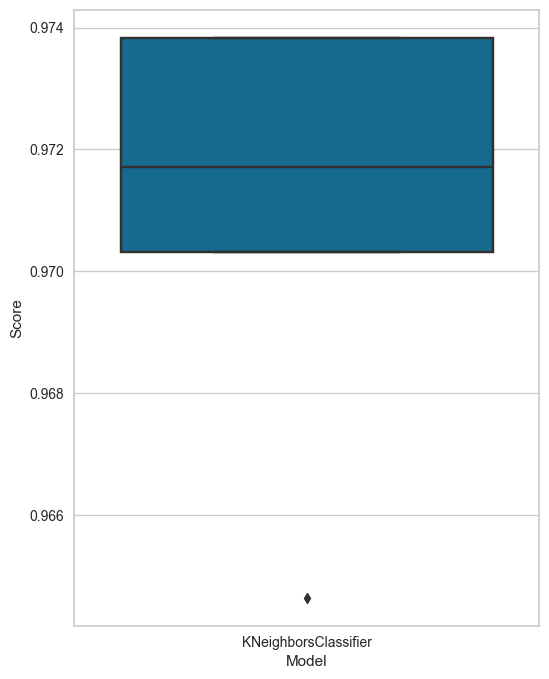

In [87]:
clf_accu = pd.DataFrame(data={'Score': cross_clf, 'Metric': 'Accuracy', 'Model': 'KNeighborsClassifier'})
plt.figure(figsize=(6,8))
sns.boxplot(data=clf_accu, x="Model", y="Score")
plt.show()

Train accuracy: 99.17% 
Test accuracy: 98.54%
Confusion Matrix


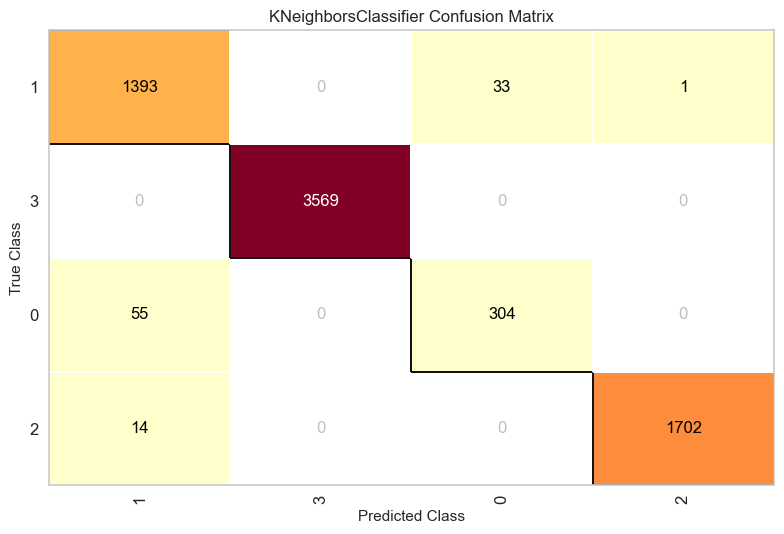

Classification Report


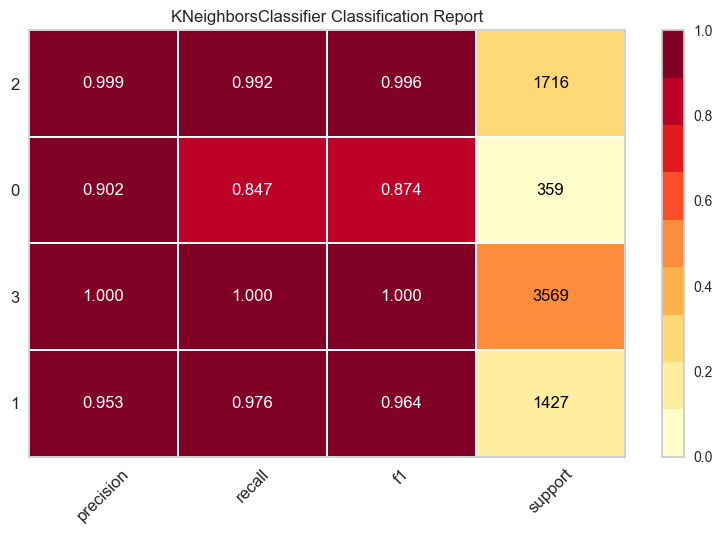

<AxesSubplot:title={'center':'KNeighborsClassifier Classification Report'}>

In [88]:
# Create the best model
best_model = KNeighborsClassifier(n_neighbors=clf_grid.best_params_['n_neighbors'])
# Fit the best model to the training data
best_model.fit(X_train, y_train)
# Accuracy
train_accuracy = accuracy_score(y_train,best_model.predict(X_train))*100
test_accuracy = accuracy_score(y_test,best_model.predict(X_test))*100
print(f'Train accuracy: {round(train_accuracy,2)}% \nTest accuracy: {round(test_accuracy,2)}%')


from yellowbrick.classifier import ConfusionMatrix, ClassificationReport, ROCAUC, roc_auc

cm = ConfusionMatrix(best_model, classes=y.unique())
# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
print('Confusion Matrix')
cm.show()

visualizer = ClassificationReport(best_model, classes=y.unique(), support=True)
visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
print('Classification Report')
visualizer.show()      


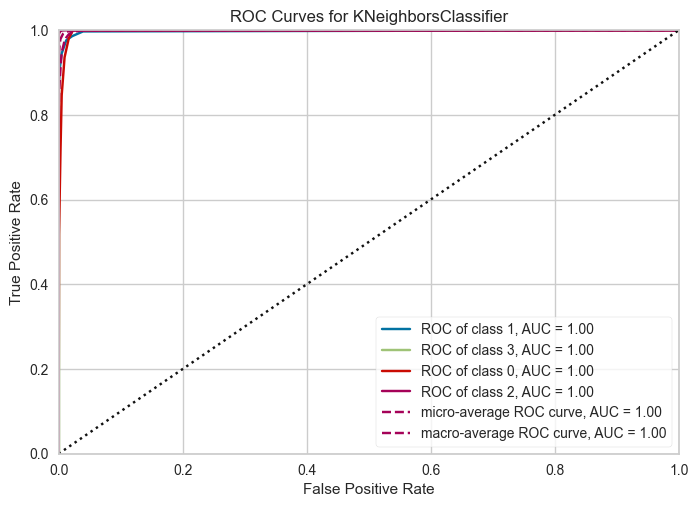

In [89]:
visualizer = ROCAUC(best_model, classes=y.unique()) 
#(estimator, ax=None, micro=True, macro=True, per_class=True, binary=False, 
# classes=None, encoder=None, is_fitted='auto', force_model=False, **kwargs)

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test,)        # Evaluate the model on the test data
visualizer.show()  
plt.show()

In [90]:
map_dict_hc

{2: 'STARS', 0: 'BIG SPENDER', 3: 'REGULAR', 1: 'RISK'}